# HW5: Regularized Linear Regression and Bias v.s. Variance

In this exercise, you will implement regularized linear regression and use it to study models with dierent bias-variance properties. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics. 

To get started with the exercise, you will need to download the starter code and unzip its contents to the directory where you wish to complete the exercise. If needed, use the cd command in Octave/MATLAB to change to this directory before starting this exercise.

You can also finnd instructions for installing Octave/MATLAB in the "Environment Setup Instructions" of the course website.

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import scipy.io
import random
from IPython.display import display, Math, Latex

# set path
import os
os.chdir('%s/courses/coursera_ml008/hw5' % os.getenv('DST'))
print(os.getcwd())

# printing options 
np.set_printoptions(linewidth=250)
np.set_printoptions(precision=3)

# plotting options
%matplotlib inline
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)
plt.rc('figure', figsize=(10, 8))

C:\Users\J28976\Documents\Development\dst\courses\coursera_ml008\hw5


## 1 Regularized Linear Regression

In the first half of the exercise, you will implement regularized linear regression to predict the amount of water 
flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance.

### 1.1 Visualing the dataset

We will begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$.

This dataset is divided into three parts:
 * A training set that your model will learn on: $X$, $y$
 * A cross validation set for determining the regularization parameter: `Xval`, `yval`
 * A test set for evaluating performance. These are "unseen" examples which your model did not see during training: `Xtest`, `ytest`
 
The next step of ex5.m will plot the training data (Figure 1). In the following parts, you will implement linear regression and use that to fit a straight line to the data and plot learning curves. Following that, you will
implement polynomial regression to find a better fit to the data.

<img src="fig1.png" width=500/>

In [2]:
ex5data1 = scipy.io.loadmat('ex5data1.mat')
X_train = ex5data1['X'   ]
X_val   = ex5data1['Xval']
X_test  = ex5data1['Xtest']

y_train = ex5data1['y'   ]
y_val   = ex5data1['yval']
y_test  = ex5data1['ytest']

In [3]:
X_train.shape, X_val.shape, X_test.shape

((12L, 1L), (21L, 1L), (21L, 1L))

In [4]:
y_train.shape, y_val.shape, y_test.shape

((12L, 1L), (21L, 1L), (21L, 1L))

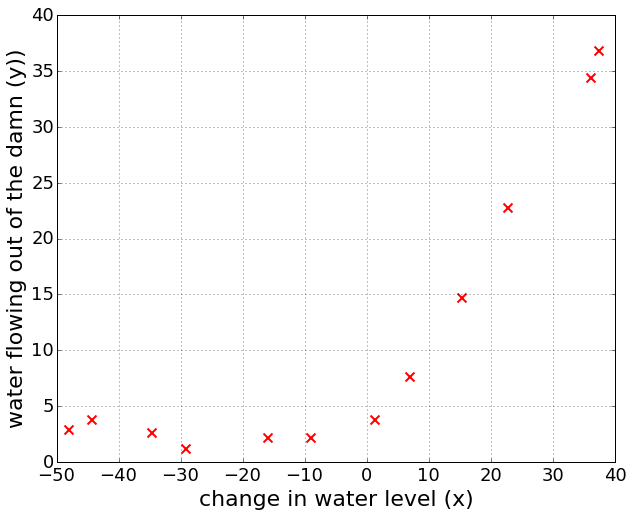

In [5]:
plt.scatter(X_train, y_train, color='r', marker='x', s=80, linewidth=2)
plt.xlabel("change in water level (x)")
plt.ylabel("water flowing out of the damn (y))")
plt.axis([-50, 40, 0, 40])
plt.grid()
plt.show()

## 1.2 Regularized linear regression cost function

Recall that regularized linear regression has the following cost function:
    
\begin{align}
J(\theta) = \frac{1}{2m}\left( \sum_{i=1}^m \left[ h_{\theta}(x^{(i)} - y^{(i)}\right]^2 \right)
- \frac{\lambda}{2m}\left( \sum_{j=1}^n \theta_j^2 \right)
\end{align}

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overal cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize the $\theta_0$ term.

You should now complete the code in the file linearRegCostFunction.m. Your task is to write a function to calculate the regularized linear regression cost function. If possible, try to vectorize your code and avoid writing loops. When you are finished, the next part of ex5.m will run your cost function using theta initialized at [1; 1]. You should expect to see an output of 303.993.

In [6]:
def prepend_ones(X):
    X    = np.asmatrix(X)
    m, n = X.shape
    return np.concatenate((np.ones((m,1)), X), axis=1)


In [7]:
def h(theta, X):
    theta = np.asmatrix(theta)
    X     = np.asmatrix(X)
    return X*theta.T

In [8]:
def cost(theta, X, y, lambda_param=0.0):
    theta   = np.asmatrix(theta)
    m       = len(X)
    X       = prepend_ones(np.asmatrix(X))
    y       = np.asmatrix(y)
    h_value = h(theta,X)
    
    J  = (1.0/(2*m)) * np.sum(np.power(h_value - y,2))
    J += (lambda_param/(2*m)) * np.sum(np.power(theta[...,1:],2))
    return J

In [9]:
cost(theta=np.array([1,1]), X=X_train, y=y_train, lambda_param=1.0)

303.99319222026429

### 1.3 Regularized linear regression gradient

Correspondingly, the partial derivative of regularized linear regression's cost for $\theta_j# is defined as

\begin{align}
\frac{\partial J(\theta)}{\partial \theta_j} 
&= \frac{1}{m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)} - y^{(i)}\right)x_j^{(i)}
& \text{for} \space j = 0 \\
\frac{\partial J(\theta)}{\partial \theta_j} 
&= \left( \frac{1}{m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)} - y^{(i)}\right)x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j
& \text{for} \space j \neq 0
\end{align}

In `linearRegCostFunction.m`, add code to calculate the gradient, returning it in the variable grad. When you are finished, the next part of ex5.m will run your gradient function using theta initialized at [1; 1]. You should expect to see a gradient of [-15.30; 598.250].

In [10]:
def grad(theta, X, y, lambda_param=0.0):
    theta   = np.asmatrix(theta)
    X       = prepend_ones(np.asmatrix(X))
    m, n    = X.shape
    y       = np.asmatrix(y)
    beta    = h(theta,X) - y
    result  = (1.0/m)*beta.T*X
    
    # regularization
    result[...,1:] += (lambda_param/m)*theta[...,1:]
    
    result = np.asarray(result).reshape(n)
    return result

In [11]:
grad(theta=np.array([1,1]), X=X_train, y=y_train, lambda_param=1.0)

array([ -15.303,  598.251])

### 1.4 Fitting Linear Regression

Once your cost function and gradient are working correctly, the next part of ex5.m will run the code in `trainLinearReg.m` to compute the optimal values of $\theta#. This training function uses `fmincg` to optimize the cost function.

In this part, we set regularization parameter #\lambda# to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta# of such low dimension. In the later parts of the exercise, you will be using polynomial regression with regularization.

Finally, the ex5.m script should also plot the best fot line, resulting in an image similar to Figure 2. The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, you will implement a function to generate learning curves that can help you debug your learning algorithm even if it is not easy to visualize the data.

<img src="fig2.png" width=500/>

In [12]:
theta0       = np.array([0,0])
lambda_param = 1.0
theta0, lambda_param

(array([0, 0]), 1.0)

In [13]:
op_result = op.minimize(
    fun=cost, 
    jac=grad, 
    x0=theta0, 
    args=(X_train, y_train, lambda_param), 
    method='CG', 
    options={'maxiter': 200, 'disp':True}
)

Optimization terminated successfully.
         Current function value: 22.379542
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


In [14]:
op_result

  status: 0
 success: True
    njev: 5
    nfev: 5
     fun: 22.379541822940265
       x: array([ 13.088,   0.368])
 message: 'Optimization terminated successfully.'
     jac: array([  1.431e-13,  -7.036e-12])

In [15]:
theta_fit = op_result.x

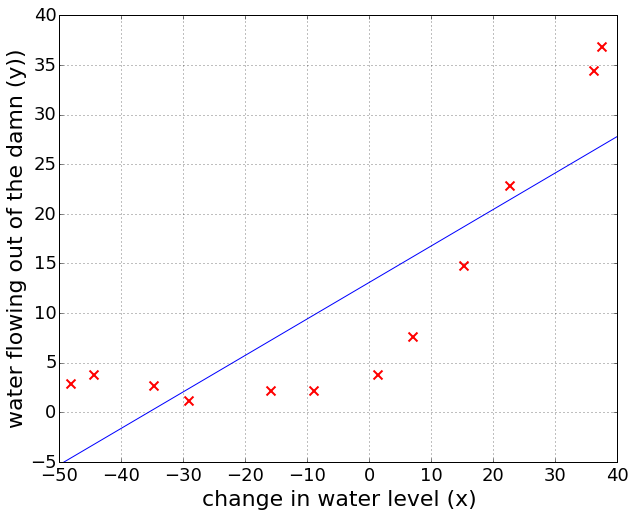

In [16]:
x   = np.linspace(-50,40,100)
fit = theta_fit[0]+theta_fit[1]*x

plt.scatter(X_train, y_train, color='r', marker='x', s=80, linewidth=2)
plt.plot(x, fit, 'b')
plt.xlabel("change in water level (x)")
plt.ylabel("water flowing out of the damn (y))")
plt.axis([-50, 40, -5, 40])
plt.grid()
plt.show()